In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io as sio

import torch
import torchvision
import torch.nn as nn   
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

from PIL import Image

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [2]:

#Collecting, assembling & resizing images for training

#Resize Dimensions:
dim_x = 208
dim_y = 108

#RINDNet output paths
rindnet_path = "C:/Users/AmineSnoussi/Desktop/SST-Edge-Detection/src/RINDNet pipeline/RINDNet-main"  #Main RINDNet directory
mat_path = rindnet_path + "/run/rindnet"                           #Matrices path
depth_path = mat_path + '/depth/mat'                               #Depth matrices directory
illu_path = mat_path + '/illumination/mat'                         #Illumination matrices directory
normal_path = mat_path + '/normal/mat'                             #Normal matrices directory
reflectance_path = mat_path + '/reflectance/mat'                   #Reflectance matrices directory

#path for the training/validation data
output_training_path = "C:/Users/AmineSnoussi/Desktop/SST-Edge-Detection/Training_Dataset/training_set"
output_validation_path = "C:/Users/AmineSnoussi/Desktop/SST-Edge-Detection/Training_Dataset/validation_set"


#number of images
n=len(os.listdir(depth_path))
i = 0

# Loop over the images in the depth directory:
for image in os.listdir(depth_path):
    try:
        # Reading the mat files:
        depth = sio.loadmat(os.path.join(depth_path, image)).get("result")
        illu = sio.loadmat(os.path.join(illu_path, image)).get("result")
        normal = sio.loadmat(os.path.join(normal_path, image)).get("result")
        reflec = sio.loadmat(os.path.join(reflectance_path, image)).get("result")

        # Assembling the 4 frames:
        result = np.concatenate((depth, illu, normal, reflec), axis=1)

        # Arrays transformations:
        img_array = (255 * (1 - result)).astype(np.uint8)
        img = Image.fromarray(img_array)

        # Image resizing:
        img = img.resize((dim_x, dim_y))

        # Splitting the dataset in 2 (training/validation):
        if i % 2 == 0:
            output_path = output_training_path
        else:
            output_path = output_validation_path

        # Saving the image:
        os.makedirs(output_path, exist_ok=True)
        img.save(os.path.join(output_path, image.replace(".mat", ".jpg")))

        # Printing the evolution of the process:
        i += 1
        if i % (n // 100) == 0:
            print(f"{i}/{n} ({100*i/n:.2f}%)")
    except Exception as e:
        print(f"Error processing file: {image}. Error message: {e}")

print("Transformation complete!")


Error processing file: README.md. Error message: index out of range
Transformation complete!


In [33]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class SSTDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.filenames = os.listdir(root_dir)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Load the SST image from file
        filename = os.path.join(self.root_dir, self.filenames[idx])
        sst_image = Image.open(filename)

        # Convert the image to grayscale
        sst_image = sst_image.convert('L')

        # Apply the transformation
        sst_image = transform(sst_image)

        return sst_image

# Define the path to your SST images
data_path = 'C:/Users/AmineSnoussi/Desktop/SST-Edge-Detection/Training_Dataset/training_set'

# Create the dataset
sst_dataset = SSTDataset(data_path)

# Define the batch size for the dataloader
batch_size = 16

# Create the dataloader
dataloader = DataLoader(sst_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Get the number of samples in the dataset
num_samples = len(sst_dataset)

print(f'Number of samples in dataset: {num_samples}')


Number of samples in dataset: 1099


Batch 0: torch.Size([16, 1, 64, 64])


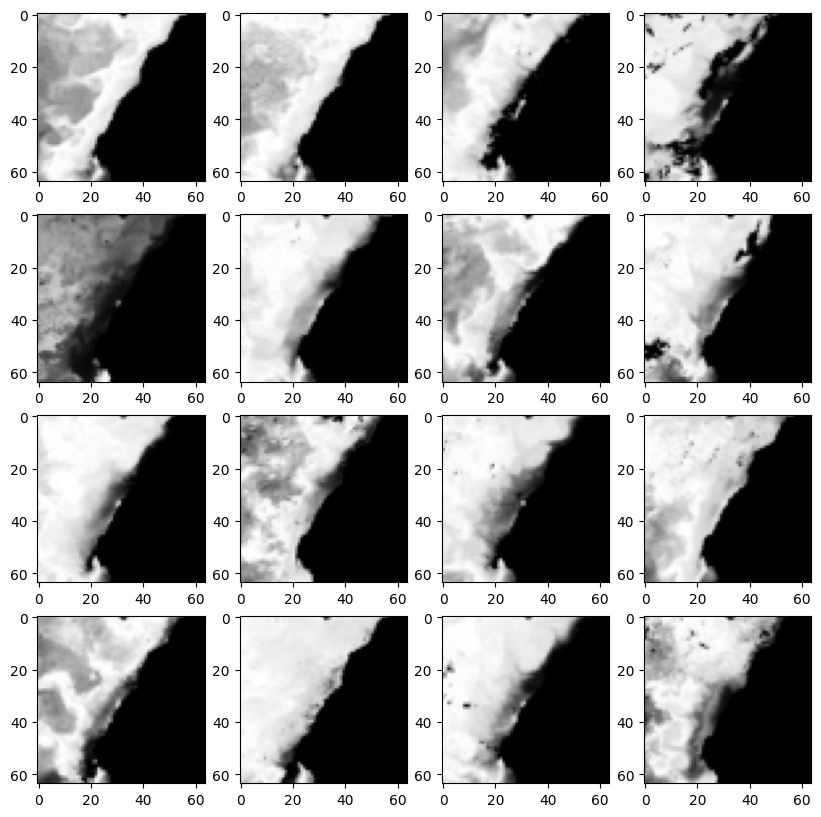

In [34]:
# Get the first batch of data
for i, batch in enumerate(dataloader):
    x = batch
    print(f"Batch {i}: {x.shape}")
    if i == 0:
        break

# Plot the first 16 images in the batch
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
for i in range(batch_size):
    row = i // 4
    col = i % 4
    axs[row, col].imshow(x[i][0], cmap='gray')
plt.show()

In [16]:
import cv2

# Read the image
img = cv2.imread('C:/Users/AmineSnoussi/Downloads/Projet-Long-master/Training_Dataset/training_set/sst_0.png', cv2.IMREAD_GRAYSCALE)

# Apply Otsu's thresholding
thresh_value, thresh_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Display the thresholded image
cv2.imshow('Thresholded Image', thresh_img)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [17]:
model = CNN()

#optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# on sélectionne les log vraisemblances pour les vraies classes:
loss_fn =  torch.nn.NLLLoss() 

In [18]:
#Training

import time
t = time.time()

train_losses = []
val_losses = []

train_accs = []
val_accs = []

# boucle d'apprentissage:
for epoch in range(10):
    print('epoch :' + str(epoch))
    
    running_loss_train = 0.
    running_corrects_train = 0.
    running_loss_val = 0.
    running_corrects_val = 0.
    
    print("Entrainement")      
    # entraînement
    for x, label in loader['train']:
        optimizer.zero_grad()
        output = model(x)   
            
        l = loss_fn(output, label)
        l.backward()     
        optimizer.step()

        #prédictions:
        _, preds = torch.max(output, 1)

        # compteurs
        running_loss_train += l.item() * x.shape[0]
        running_corrects_train += torch.sum(preds == label.data)
        


    # calcul et stockage des scores d'entraînement

    epoch_loss_train = running_loss_train / dataset_sizes['train']
    epoch_acc_train = running_corrects_train.float() / dataset_sizes['train']  

    train_losses.append(epoch_loss_train)
    train_accs.append(epoch_acc_train)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        'train', epoch_loss_train, epoch_acc_train))

    print("Validation")        
    
    # validation
    model.eval()

    for x, label in loader['val']:
                
        with torch.no_grad():
            output = model(x)
            l = loss_fn(output, label)        
            
        # prédictions:
        _, preds = torch.max(output, 1)

        # compteurs:
        running_loss_val += l.item() * x.shape[0]
        running_corrects_val += torch.sum(preds == label.data)
        
    
    # calcul et stockage des scores en validation
    epoch_loss_val = running_loss_val / dataset_sizes['val']
    epoch_acc_val = running_corrects_val.float() / dataset_sizes['val']    

    val_losses.append(epoch_loss_val)
    val_accs.append(epoch_acc_val)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        'val', epoch_loss_val, epoch_acc_val))

    new_t = time.time()
    print('time ' +str(round(new_t- t)))
    t = new_t
    
    


epoch :0
Entrainement
train Loss: 3.1563 Acc: 0.3546
Validation
val Loss: 2.9016 Acc: 0.4161
time 25
epoch :1
Entrainement
train Loss: 2.7967 Acc: 0.4137
Validation
val Loss: 2.6811 Acc: 0.4161
time 24
epoch :2
Entrainement
train Loss: 2.4942 Acc: 0.4137
Validation
val Loss: 2.5379 Acc: 0.4208
time 24
epoch :3
Entrainement
train Loss: 2.1673 Acc: 0.4303
Validation
val Loss: 2.3829 Acc: 0.4444
time 24
epoch :4
Entrainement
train Loss: 1.9391 Acc: 0.4681
Validation
val Loss: 2.3525 Acc: 0.4539
time 24
epoch :5
Entrainement
train Loss: 1.6358 Acc: 0.5201
Validation
val Loss: 2.3626 Acc: 0.4941
time 24
epoch :6
Entrainement
train Loss: 1.3321 Acc: 0.6005
Validation
val Loss: 2.3049 Acc: 0.5296
time 24
epoch :7
Entrainement
train Loss: 1.0216 Acc: 0.7116
Validation
val Loss: 2.2408 Acc: 0.5485
time 24
epoch :8
Entrainement
train Loss: 0.7476 Acc: 0.7636
Validation
val Loss: 2.6528 Acc: 0.5863
time 24
epoch :9
Entrainement
train Loss: 0.5185 Acc: 0.8416
Validation
val Loss: 2.3496 Acc: 0.588

In [68]:
#Sauvegarde des poids du réseau (utile pour évaluation plus tard)
save_path = 'trained_model_208.pth'

torch.save(model, save_path)


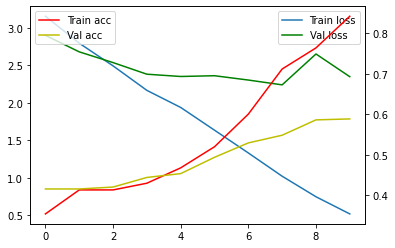

In [19]:
#Affichage des courbes d'apprentissage

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(train_losses)
ax2.plot(train_accs, 'r-')
ax1.plot(val_losses, 'g-')
ax2.plot(val_accs, 'y-')
ax1.legend(['Train loss', 'Val loss'])
ax2.legend(['Train acc', 'Val acc'])

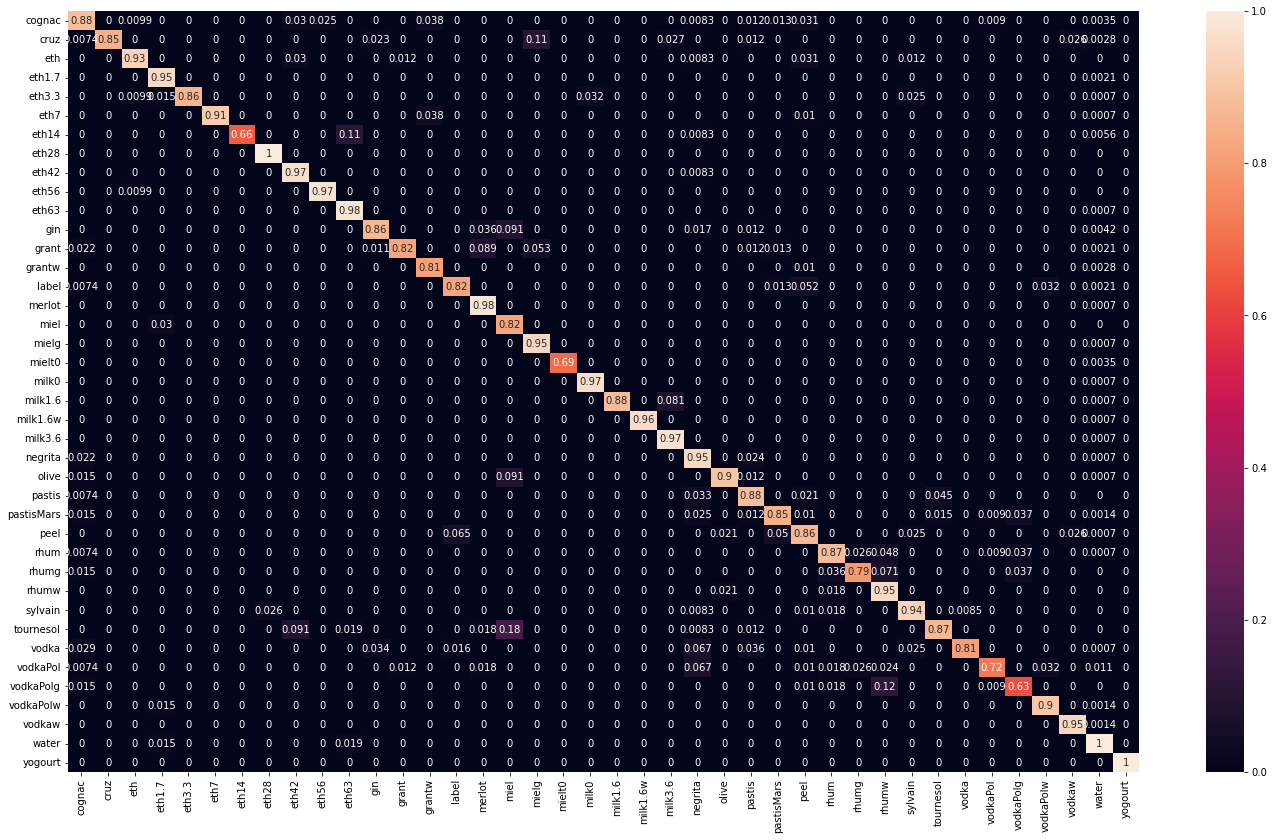

In [13]:
#Computing, showing and saving the confusion matrix on the validation dataset


#Save path
image_path = 'confusion_val.png'



y_pred = []
y_true = []

# iterate over test data
for inputs, labels in loader['val']:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = list(dico.values())

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (24,14))
sn.heatmap(df_cm, annot=True)
plt.savefig(image_path)